In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_uniform_sections(max_x, max_y, n):
    unique_x = np.random.uniform(0, max_x, size=(n,2))
    result = []
    for x1, x2 in unique_x:
        result.append( ((min(x1, x2),np.random.uniform(0, max_y)), (max(x1,x2),np.random.uniform(0, max_y))) )
    return result

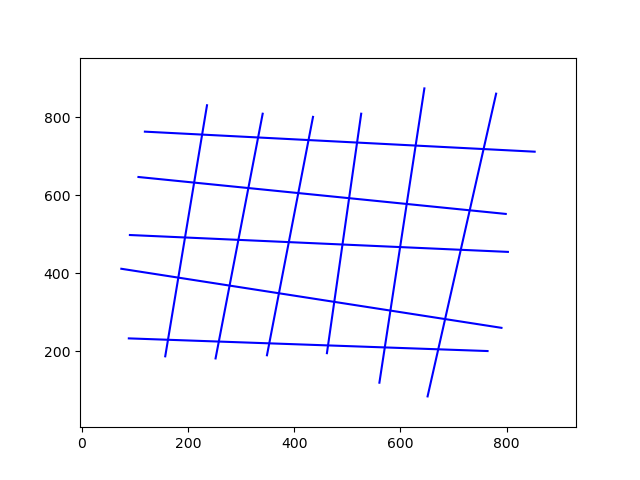

In [19]:
from matplotlib.backend_bases import MouseButton
%matplotlib widget

section = [((157.25806451612905, 187.22943722943722), (235.88709677419357, 831.1688311688312)), ((252.01612903225808, 181.8181818181818), (340.7258064516129, 809.5238095238095)), ((348.7903225806451, 189.93506493506493), (435.48387096774195, 801.4069264069265)), ((461.6935483870968, 195.34632034632034), (526.2096774193549, 809.5238095238095)), ((560.483870967742, 119.58874458874459), (645.1612903225807, 874.4588744588744)), ((651.2096774193549, 84.41558441558439), (780.241935483871, 860.930735930736)), ((118.95161290322582, 763.5281385281386), (852.8225806451613, 712.1212121212121)), ((106.85483870967741, 647.1861471861472), (798.3870967741935, 552.4891774891776)), ((90.7258064516129, 498.37662337662334), (802.4193548387098, 455.08658008658006)), ((74.59677419354838, 411.79653679653677), (790.3225806451613, 260.28138528138527)), ((88.70967741935485, 233.22510822510822), (764.1129032258065, 200.75757575757575))]


MODE = 1 # 0 - nowy zbiór | 1 - dopisywanie
# [ ((x1,y1), (x2,y2))]
if MODE == 0:
    limit_x = (0, 1000)
    limit_y = (0, 1000)
    section = []
    points_x = []
    points_y = []
else:
    minx = float("inf")
    maxx = -float("inf")
    miny = float("inf")
    maxy = -float("inf")
    points_x = []
    points_y = []
    for line in section:
        minx = min(minx, line[0][0], line[1][0])
        maxx = max(maxx, line[0][0], line[1][0])
        miny = min(miny, line[0][1], line[1][1])
        maxy = max(maxy, line[0][1], line[1][1])
        points_x.append(line[0][0])
        points_x.append(line[1][0])
        points_y.append(line[0][1])
        points_y.append(line[1][1])
    width = maxx - minx
    height = maxy - miny
    limit_x = (minx - width/10, maxx + width/10)
    limit_y = (miny - height/10, maxy + height/10)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(limit_x)
ax.set_ylim(limit_y)

for i in range(1, len(points_x), 2):
    plt.plot(points_x[i-1:i+1], points_y[i-1:i+1], c='blue')

eps = (limit_x[1]-limit_x[0])/100
finished = False

def onclick(event):
    global finished, section, points_x, points_y
    if event.button is MouseButton.RIGHT:
        finished = True
        if len(points_x) % 2 == 1: points_x.pop()
        if len(points_y) % 2 == 1: points_y.pop()
        section = []
        for i in range(1, len(points_x), 2):
            if points_x[i-1] < points_x[i]:
                section.append(((points_x[i-1], points_y[i-1]), (points_x[i], points_y[i])))
            else:
                section.append(((points_x[i], points_y[i]), (points_x[i-1], points_y[i-1])))
    if not finished and event.xdata not in points_x:
        points_x.append(event.xdata)
        points_y.append(event.ydata)
        col = 'blue'
    if finished:
        col = 'green'
    for i in range(1, len(points_x), 2):
        plt.plot(points_x[i-1:i+1], points_y[i-1:i+1], c=col)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [10]:
def save_sections_to_file(sections, file_path):
    with open(file_path, 'w') as file:
        for section in sections:
                file.write(f"{section[0][0]} {section[0][1]} {section[1][0]} {section[1][1]}\n")

def read_sections_from_file(file_path):
    sections = []
    with open(file_path, 'r') as file:
        for line in file:
            coords = list(map(lambda x: float(x), line.trim().split(line)))
            sections.append(((coords[0], coords[1]), (coords[2], coords[3])))
    
    return sections

In [11]:
eps = 1e-12

def det(a, b, c):
    return (a[0] - c[0]) * (b[1] - c[1]) - (b[0] - c[0]) * (a[1] - c[1])

def orient(a, b, c):
    global eps
    d = det(a, b, c)
    if d > eps:
        return 1
    elif d < -eps:
        return -1
    return 0

def is_point_on_segment(segment, point):
    return orient(segment[0], segment[1], point) == 0

def check(s1, s2):
    a, b = s1
    c, d = s2
    return (orient(a, b, c) != orient(a, b, d) and orient(c, d, a) != orient(c, d, b))

def get_intersection_point(s1, s2):
    s1 = s1.get_section()
    s2 = s2.get_section()
    if not check(s1, s2): return None

    a_1 = (s1[1][1] - s1[0][1]) / (s1[1][0] - s1[0][0])
    b_1 = s1[0][1] - a_1 * s1[0][0]

    a_2 = (s2[1][1] - s2[0][1]) / (s2[1][0] - s2[0][0])
    b_2 = s2[0][1] - a_2 * s2[0][0]

    x = (b_2 - b_1) / (a_1 - a_2)
    y = a_1 * (b_2 - b_1) / (a_1 - a_2) + b_1

    return x, y

In [12]:
from sortedcontainers import SortedSet
from queue import PriorityQueue

class Section:
    def __init__(self, section, idx):
        self.start = section[0]
        self.end = section[1]
        self.a = (self.start[1]-self.end[1])/(self.start[0]-self.end[0])
        self.b = (self.start[1]-self.a*self.start[0])
        self.idx = idx

    def set_ordering(x):
        Section.ordering_x = x
        
    def get_section(self):
        return (self.start, self.end)

    def __eq__(self, other):
        return self.idx == other.idx
    
    def __gt__(self, other):
        x = Section.ordering_x
        if self.a*x+self.b == other.a*x+other.b:
            return self.start[1] > other.start[1]
        return self.a*x+self.b > other.a*x+other.b

    def __hash__(self):
        return id(self)


def is_intersection(sections):
    Q = PriorityQueue()
    T = SortedSet()
    
    def insert(point, sec):
        nonlocal T, Q
        Section.set_ordering(point)
        
        T.add(sec)
        idx = T.index(sec)
        
        if idx == 0 and len(T) > 1:
            p = get_intersection_point(sec, T[idx+1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
        elif idx == len(T)-1:
            p = get_intersection_point(sec, T[idx-1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
        else:
            p = get_intersection_point(sec, T[idx+1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
            p = get_intersection_point(sec, T[idx-1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
            
    
    for i, s in enumerate(sections):
        Q.put((s[0][0], Section(s, i), "S")) # Start point of section
        Q.put((s[1][0], Section(s, i), "E")) # End point of section
        
    while not Q.empty():
        point, sec, event = Q.get()
        if event == 'S':
            insert(point, sec)
        elif event == 'E':
            idx = T.index(sec)
            T.pop(idx)
            if 0 < idx < len(T)-1:
                p = get_intersection_point(T[idx], T[idx-1])
                if p:
                    Q.put((p[0], (T[idx], T[idx-1]), "I"))
        else:
            return True
        
    return False

In [13]:
is_intersection(section)

True

In [48]:
import io
import matplotlib.animation as animation
from PIL import Image

def is_intersection_with_visualization(sections, filename="output.gif"):
    Q = PriorityQueue()
    T = SortedSet()
    
    def insert(point, sec):
        nonlocal T, Q
        Section.set_ordering(point)
        
        T.add(sec)
        idx = T.index(sec)
        
        if idx == 0 and len(T) > 1:
            p = get_intersection_point(sec, T[idx+1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
        elif idx == len(T)-1:
            p = get_intersection_point(sec, T[idx-1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
        else:
            p = get_intersection_point(sec, T[idx+1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
            p = get_intersection_point(sec, T[idx-1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
        
    frames = []

    for i, s in enumerate(sections):
        Q.put((s[0][0], Section(s, i), "S"))  # Start
        Q.put((s[1][0], Section(s, i), "E"))  # End
    
    while not Q.empty():
        point, sec, event = Q.get()
        
        fig, ax = plt.subplots()
        for s in sections:
            x = [s[0][0], s[1][0]]
            y = [s[0][1], s[1][1]]
            ax.plot(x, y, color='gray', linestyle='--', zorder=1)
        
        for s in T:
            x = [s.get_section()[0][0], s.get_section()[1][0]]
            y = [s.get_section()[0][1], s.get_section()[1][1]]
            ax.plot(x, y, color='red', linewidth=2, zorder=2)
        
        if event == 'S' or event == 'E':
            ax.scatter(point, point*sec.a + sec.b, color='orange', s=50, zorder=3)
            ax.set_title(f"Event: {event}, Point: {point}")
            ax.set_xlim(0, 1000)
            ax.set_ylim(0, 1000)
            plt.close(fig)
        
        frames.append(fig)
        
        if event == 'S':
            insert(point, sec)
        elif event == 'E':
            idx = T.index(sec)
            T.pop(idx)
        else:
            ax.scatter(point, point*sec[0].a + sec[0].b, color='green', s=100, zorder=3)
            ax.set_title(f"Event: {event}, Point: {point}")
            ax.set_xlim(0, 1000)
            ax.set_ylim(0, 1000)
            plt.close(fig)
            
            images = []
            for fig in frames:
                buf = io.BytesIO()
                fig.savefig(buf, format="png")
                buf.seek(0)
                images.append(Image.open(buf))
            images[0].save(
                filename, save_all=True, append_images=images[1:], duration=500, loop=0
            )
            return True

    images = []
    for fig in frames:
        buf = io.BytesIO()
        fig.savefig(buf, format="png")
        buf.seek(0)
        images.append(Image.open(buf))
    images[0].save(
        filename, save_all=True, append_images=images[1:], duration=500, loop=0
    )
    return False

In [49]:
is_intersection_with_visualization(section)

True

In [25]:
def find_intersections(sections, eps=1e-12):
    Q = PriorityQueue()
    T = SortedSet()

    result = set()
    intersections = []

    for i, s in enumerate(sections):
        Q.put((s[0][0], Section(s, i), "S"))
        Q.put((s[1][0], Section(s, i), "E"))


    def insert(point, sec):
        nonlocal T, Q
        Section.set_ordering(point)
        
        T.add(sec)
        idx = T.index(sec)
        
        if idx == 0 and len(T) > 1:
            p = get_intersection_point(sec, T[idx+1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
        elif idx == len(T)-1:
            p = get_intersection_point(sec, T[idx-1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
        else:
            p = get_intersection_point(sec, T[idx+1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
            p = get_intersection_point(sec, T[idx-1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))

    def intersection(point, sec):
        nonlocal T, eps, sections, result
        T.pop(T.index(sec[0]))
        T.pop(T.index(sec[1]))
        Section.set_ordering(point+eps)
        
        T.add(sec[0])
        T.add(sec[1])
        
        idxf = T.index(sec[0])
        idxs = T.index(sec[1])
        
        for idx, sec in ((idxf, sec[0]), (idxs, sec[1])):
            if idx == 0 and len(T) > 1:
                p = get_intersection_point(sec, T[idx+1])
                if p and p[0] > point+eps:
                    Q.put((p[0], (sec, T[idx-1]), "I"))
            elif idx == len(T)-1:
                p = get_intersection_point(sec, T[idx-1])
                if p and p[0] > point+eps:
                    Q.put((p[0], (sec, T[idx-1]), "I"))
            else:
                p = get_intersection_point(sec, T[idx+1])
                if p and p[0] > point+eps:
                    Q.put((p[0], (sec, T[idx-1]), "I"))
                p = get_intersection_point(sec, T[idx-1])
                if p and p[0] > point+eps:
                    Q.put((p[0], (sec, T[idx-1]), "I"))
                    
                    

    while not Q.empty():
        point, sec, event = Q.get()
        if event == 'S':
            insert(point, sec)
        elif event == 'E':
            idx = T.index(sec)
            T.pop(idx)
            if 0 < idx < len(T)-1:
                p = get_intersection_point(T[idx], T[idx-1])
                if p:
                    Q.put((p[0], (T[idx], T[idx-1]), "I"))
        else:
            intersection(point, sec)
            result.add((sec[0].idx, sec[1].idx))
            
    for i, j in result:
        intersections.append((get_intersection_point(Section(section[i], i), Section(section[j], j)), i, j))
            
    return intersections, len(result)

In [26]:
# section = [((1, 1), (2, 2)), ((1, 0), (2, 8))]
find_intersections(section)

([((581.2312876216037, 304.54484295944076), 4, 9),
  ((503.4520603362753, 592.8769596677066), 3, 7),
  ((628.7120931340756, 727.8199273517002), 4, 6),
  ((463.77855327672864, 215.19504790089286), 3, 10),
  ((730.532713351111, 561.781013720803), 5, 7),
  ((671.2835514593568, 205.2200063135133), 5, 10),
  ((332.1152967466575, 748.5962359326645), 1, 6),
  ((194.48046385784164, 492.06555926646206), 0, 8),
  ((278.4196613557332, 368.64837118303126), 1, 9),
  ((389.9402913512659, 480.17636283798356), 2, 8),
  ((475.51513262980154, 326.9243618992332), 3, 9),
  ((756.6341259579684, 718.8591170508967), 5, 6),
  ((599.5028268382257, 467.4293437681026), 4, 8),
  ((518.4385362102937, 735.5444795885232), 3, 6),
  ((684.1672289273808, 282.7538797124648), 5, 9),
  ((211.66906305517088, 632.8331082484744), 0, 7),
  ((162.44163135755133, 229.68071501389022), 0, 10),
  ((407.7763395140574, 605.9785911965027), 2, 7),
  ((353.12579612578213, 220.5142732882614), 2, 10),
  ((294.99736389908617, 485.95143758

In [52]:
def find_intersections_with_visualisation(sections, filename="all.gif", eps=1e-12):
    Q = PriorityQueue()
    T = SortedSet()
    frames = []
    result = set()

    for i, s in enumerate(sections):
        Q.put((s[0][0], Section(s, i), "S"))
        Q.put((s[1][0], Section(s, i), "E"))


    def insert(point, sec):
        nonlocal T, Q
        Section.set_ordering(point)
        
        T.add(sec)
        idx = T.index(sec)
        
        if idx == 0 and len(T) > 1:
            p = get_intersection_point(sec, T[idx+1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
        elif idx == len(T)-1:
            p = get_intersection_point(sec, T[idx-1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
        else:
            p = get_intersection_point(sec, T[idx+1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))
            p = get_intersection_point(sec, T[idx-1])
            if p:
                Q.put((p[0], (sec, T[idx-1]), "I"))

    def intersection(point, sec):
        nonlocal T, eps, sections, result
        T.pop(T.index(sec[0]))
        T.pop(T.index(sec[1]))
        Section.set_ordering(point+eps)
        
        T.add(sec[0])
        T.add(sec[1])
        
        idxf = T.index(sec[0])
        idxs = T.index(sec[1])
        
        for idx, sec in ((idxf, sec[0]), (idxs, sec[1])):
            if idx == 0 and len(T) > 1:
                p = get_intersection_point(sec, T[idx+1])
                if p and p[0] > point+eps:
                    Q.put((p[0], (sec, T[idx-1]), "I"))
            elif idx == len(T)-1:
                p = get_intersection_point(sec, T[idx-1])
                if p and p[0] > point+eps:
                    Q.put((p[0], (sec, T[idx-1]), "I"))
            else:
                p = get_intersection_point(sec, T[idx+1])
                if p and p[0] > point+eps:
                    Q.put((p[0], (sec, T[idx-1]), "I"))
                p = get_intersection_point(sec, T[idx-1])
                if p and p[0] > point+eps:
                    Q.put((p[0], (sec, T[idx-1]), "I"))

    intersect_points = []

    while not Q.empty():
        point, sec, event = Q.get()
        
        fig, ax = plt.subplots()
        for s in sections:
            x = [s[0][0], s[1][0]]
            y = [s[0][1], s[1][1]]
            ax.plot(x, y, color='gray', linestyle='--', zorder=1)
        
        for s in T:
            x = [s.get_section()[0][0], s.get_section()[1][0]]
            y = [s.get_section()[0][1], s.get_section()[1][1]]
            ax.plot(x, y, color='red', linewidth=2, zorder=2)
        
        if event == 'S' or event == 'E':
            ax.scatter(point, point*sec.a + sec.b, color='orange', s=50, zorder=3)
            ax.set_title(f"Event: {event}, Point: {point}")
            ax.set_xlim(0, 1000)
            ax.set_ylim(0, 1000)
            plt.close(fig)
        
        
        for x, y in intersect_points:
            ax.scatter(x, y, color='green', s=100, zorder=3)
            ax.set_xlim(0, 1000)
            ax.set_ylim(0, 1000)
            plt.close(fig)
        
        
        if event == 'S':
            insert(point, sec)
        elif event == 'E':
            idx = T.index(sec)
            T.pop(idx)
            if 0 < idx < len(T)-1:
                p = get_intersection_point(T[idx], T[idx-1])
                if p:
                    Q.put((p[0], (T[idx], T[idx-1]), "I"))
        else:
            ax.scatter(point, point*sec[0].a + sec[0].b, color='green', s=100, zorder=3)
            ax.set_title(f"Event: {event}, Point: {point}")
            ax.set_xlim(0, 1000)
            ax.set_ylim(0, 1000)
            plt.close(fig)
            
            intersect_points.append((point, point*sec[0].a + sec[0].b))
            
            intersection(point, sec)
            result.add((sec[0].idx, sec[1].idx))
            
        frames.append(fig)
            
            
    images = []
    for fig in frames:
        buf = io.BytesIO()
        fig.savefig(buf, format="png")
        buf.seek(0)
        images.append(Image.open(buf))
    images[0].save(
        filename, save_all=True, append_images=images[1:], duration=500, loop=0
    )

In [53]:
find_intersections_with_visualisation(section)